In [2]:
# Cell 1: Import required libraries with additions for handling imbalance
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense, Dropout, Input, 
    Bidirectional, LayerNormalization, Concatenate
)
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('Task4/processed_emotions_extended.csv')

In [6]:
# Cell 2: Define emotion mappings and improved helper functions
emotion_mapping = {
    "happiness": [
        "joy", "optimism", "approval", "pride", "gratitude",
        "love", "excitement", "caring", "relief", "admiration",
        "amusement", "desire"
    ],
    "sadness": [
        "disappointment", "remorse", "grief", "sadness"
    ],
    "anger": [
        "anger", "annoyance", "disapproval"
    ],
    "disgust": [
        "disgust"
    ],
    "fear": [
        "fear", "nervousness"
    ],
    "surprise": [
        "surprise", "realization"
    ],
    "neutral": [
        "neutral"
    ]
}

def create_core_emotion_labels(row, emotion_mapping):
    """Create binary labels for core emotions based on the mapping"""
    core_emotions = {core: 0 for core in emotion_mapping.keys()}
    
    for core_emotion, sub_emotions in emotion_mapping.items():
        for emotion in sub_emotions:
            if emotion in row and row[emotion] == 1:
                core_emotions[core_emotion] = 1
                break
    
    return pd.Series(core_emotions)

def focal_loss(gamma=2., alpha=.25):
    """Define focal loss for better handling of class imbalance"""
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -tf.reduce_mean(
            alpha * tf.pow(1. - pt_1, gamma) * tf.log(tf.clip_by_value(pt_1, 1e-7, 1.)) +
            (1-alpha) * tf.pow(pt_0, gamma) * tf.log(tf.clip_by_value(1. - pt_0, 1e-7, 1.))
        )
    return focal_loss_fixed

In [ ]:
core_emotions.head()

In [7]:
# Cell 3: Load and prepare data with improved analysis
# Load the processed data


# Create core emotion labels
core_emotion_labels = df.apply(lambda x: create_core_emotion_labels(x, emotion_mapping), axis=1)

# Analyze text lengths
text_lengths = df['text'].str.split().str.len()
print(f"Average text length: {text_lengths.mean():.1f}")
print(f"95th percentile length: {text_lengths.quantile(0.95):.1f}")
print(f"Max text length: {text_lengths.max()}")

# Display class distribution and calculate weights
print("\nEmotion Distribution and Weights:")
total_samples = len(df)
class_weights = {}
for emotion in emotion_mapping.keys():
    count = core_emotion_labels[emotion].sum()
    percentage = (count / total_samples) * 100
    weight = total_samples / (len(emotion_mapping) * count)
    class_weights[list(emotion_mapping.keys()).index(emotion)] = weight
    print(f"{emotion}: {count} ({percentage:.2f}%) - Weight: {weight:.2f}")

Average text length: 13.0
95th percentile length: 24.0
Max text length: 33

Emotion Distribution and Weights:
happiness: 82938 (39.27%) - Weight: 0.36
sadness: 17050 (8.07%) - Weight: 1.77
anger: 30473 (14.43%) - Weight: 0.99
disgust: 5301 (2.51%) - Weight: 5.69
fear: 4515 (2.14%) - Weight: 6.68
surprise: 13999 (6.63%) - Weight: 2.16
neutral: 55298 (26.18%) - Weight: 0.55


In [8]:
# Cell 4: Enhanced data preprocessing
# Adjust parameters based on data analysis
MAX_LENGTH = 400  # Increased based on text length analysis
VOCAB_SIZE = 20000  # Increased for better coverage
EMBEDDING_DIM = 300  # Increased for better representation
BATCH_SIZE = 32  # Reduced for better handling of minority classes

# Tokenize texts with improved preprocessing
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')

# Prepare features
sentiment_scores = df['Sentiment_Score'].values.reshape(-1, 1)

# Convert embeddings string to numpy array safely
def string_to_array(embedding_str):
    try:
        # Remove brackets and split by spaces
        values = embedding_str.strip('[]').split()
        # Convert to float array
        return np.array([float(x) for x in values])
    except:
        # Return zero array if conversion fails
        return np.zeros(300)  # assuming 300-dim embeddings

# Convert embeddings
pretrained_embeddings = np.array([
    string_to_array(str(emb)) for emb in df['Pretrained_Embeddings']
])
custom_embeddings = np.array([
    string_to_array(str(emb)) for emb in df['Custom_Embeddings']
])

# Normalize numerical features
scaler = StandardScaler()
sentiment_scores = scaler.fit_transform(sentiment_scores)

# Prepare labels
labels = core_emotion_labels.values

print("Features prepared:")
print(f"Text sequences shape: {padded_sequences.shape}")
print(f"Sentiment scores shape: {sentiment_scores.shape}")
print(f"Pretrained embeddings shape: {pretrained_embeddings.shape}")
print(f"Custom embeddings shape: {custom_embeddings.shape}")
print(f"Labels shape: {labels.shape}")

# Verify no NaN values
print("\nChecking for NaN values:")
print(f"NaN in sentiment scores: {np.isnan(sentiment_scores).any()}")
print(f"NaN in pretrained embeddings: {np.isnan(pretrained_embeddings).any()}")
print(f"NaN in custom embeddings: {np.isnan(custom_embeddings).any()}")

Features prepared:
Text sequences shape: (211225, 400)
Sentiment scores shape: (211225, 1)
Pretrained embeddings shape: (211225, 100)
Custom embeddings shape: (211225, 100)
Labels shape: (211225, 7)

Checking for NaN values:
NaN in sentiment scores: False
NaN in pretrained embeddings: False
NaN in custom embeddings: False


In [9]:
# Cell 5: Improved model architecture
def build_emotion_classifier():
    # Text input branch
    text_input = Input(shape=(MAX_LENGTH,))
    embedding = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH)(text_input)
    
    # Multiple BiLSTM layers with residual connections
    lstm_1 = Bidirectional(LSTM(128, return_sequences=True))(embedding)
    lstm_1 = LayerNormalization()(lstm_1)
    lstm_1 = Dropout(0.2)(lstm_1)
    
    lstm_2 = Bidirectional(LSTM(64, return_sequences=True))(lstm_1)
    lstm_2 = LayerNormalization()(lstm_2)
    lstm_2 = Dropout(0.2)(lstm_2)
    
    lstm_3 = Bidirectional(LSTM(32))(lstm_2)
    lstm_3 = LayerNormalization()(lstm_3)
    lstm_3 = Dropout(0.2)(lstm_3)

    # Pretrained embeddings branch
    pretrained_input = Input(shape=(pretrained_embeddings.shape[1],))
    pretrained_dense = Dense(64, activation='relu')(pretrained_input)
    
    # Custom embeddings branch
    custom_input = Input(shape=(custom_embeddings.shape[1],))
    custom_dense = Dense(64, activation='relu')(custom_input)
    
    # Sentiment input branch
    sentiment_input = Input(shape=(1,))
    sentiment_dense = Dense(32, activation='relu')(sentiment_input)
    
    # Combine all features
    combined = Concatenate()(
        [lstm_3, pretrained_dense, custom_dense, sentiment_dense]
    )
    
    # Dense layers with residual connections
    dense_1 = Dense(256, activation='relu')(combined)
    dense_1 = LayerNormalization()(dense_1)
    dense_1 = Dropout(0.3)(dense_1)
    
    dense_2 = Dense(128, activation='relu')(dense_1)
    dense_2 = LayerNormalization()(dense_2)
    dense_2 = Dropout(0.3)(dense_2)
    
    # Output layer for multi-label classification
    output = Dense(len(emotion_mapping), activation='sigmoid')(dense_2)
    
    # Create model
    model = Model(
        inputs=[text_input, pretrained_input, custom_input, sentiment_input],
        outputs=output
    )
    
    # Compile with focal loss
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=focal_loss(gamma=2.0),
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC()
        ]
    )
    
    return model

In [10]:
# Cell 6: Improved data splitting and model creation
# Split data with stratification
X_train_seq, X_test_seq, X_train_pre, X_test_pre, X_train_cust, X_test_cust, \
X_train_sent, X_test_sent, y_train, y_test = train_test_split(
    padded_sequences,
    pretrained_embeddings,
    custom_embeddings,
    sentiment_scores,
    labels,
    test_size=0.15,
    random_state=42,
    stratify=labels.argmax(axis=1)
)

# Create model
model = build_emotion_classifier()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 400, 300)     6000000     ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 400, 256)     439296      ['embedding[0][0]']              
                                                                                                  
 layer_normalization (LayerNorm  (None, 400, 256)    512         ['bidirectional[0][0]']          
 alization)                                                                                   

In [11]:
# Cell 7: Enhanced training with monitoring
class MultiLabelF1Callback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, emotion_mapping):
        super().__init__()
        self.validation_data = validation_data
        self.emotion_mapping = emotion_mapping
        self.best_f1 = 0
        
    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.validation_data[0])
        y_pred_classes = (y_pred > 0.5).astype(int)
        
        # Calculate F1 score for each emotion
        for i, emotion in enumerate(self.emotion_mapping.keys()):
            f1 = f1_score(self.validation_data[1][:, i], y_pred_classes[:, i])
            print(f"\n{emotion} F1: {f1:.4f}")
        
        # Calculate overall F1
        f1_macro = f1_score(self.validation_data[1], y_pred_classes, average='macro')
        print(f"\nOverall F1: {f1_macro:.4f}")
        
        if f1_macro > self.best_f1:
            self.best_f1 = f1_macro
            print(f"New best F1 score: {f1_macro:.4f}")

# Training parameters
EPOCHS = 20
VALIDATION_SPLIT = 0.25

# Define weighted binary crossentropy loss
def weighted_binary_crossentropy():
    def loss(y_true, y_pred):
        # Convert y_true to float32 to match y_pred
        y_true = tf.cast(y_true, tf.float32)
        
        # Clip prediction values to avoid log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        
        # Calculate binary crossentropy
        bce = -(y_true * tf.math.log(y_pred) + 
                (1 - y_true) * tf.math.log(1 - y_pred))
        
        # Apply class weights
        weights = tf.constant([
            class_weights[i] for i in range(len(emotion_mapping))
        ], dtype=tf.float32)
        
        # Weight the losses
        weighted_bce = bce * weights
        
        return tf.reduce_mean(weighted_bce)
    return loss

# Recompile model with weighted loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=weighted_binary_crossentropy(),
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    MultiLabelF1Callback(
        ([X_test_seq, X_test_pre, X_test_cust, X_test_sent], y_test),
        emotion_mapping
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=5,
        min_lr=0.0001
    )
]

# Train model
history = model.fit(
    [X_train_seq, X_train_pre, X_train_cust, X_train_sent],
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    callbacks=callbacks,
    shuffle=True
)

Epoch 1/20
991/991 [==============================] - 132s 131ms/step

happiness F1: 0.6483

sadness F1: 0.3250

anger F1: 0.0415

disgust F1: 0.0000

fear F1: 0.3444

surprise F1: 0.0158

neutral F1: 0.0920

Overall F1: 0.2096
New best F1 score: 0.2096
4208/4208 [==============================] - 2143s 506ms/step - loss: 0.4295 - accuracy: 0.4867 - val_loss: 0.3947 - val_accuracy: 0.5262 - lr: 0.0010
Epoch 2/20
991/991 [==============================] - 184s 186ms/step

happiness F1: 0.6655

sadness F1: 0.3052

anger F1: 0.1169

disgust F1: 0.0401

fear F1: 0.3177

surprise F1: 0.0084

neutral F1: 0.1512

Overall F1: 0.2293
New best F1 score: 0.2293
4208/4208 [==============================] - 2454s 583ms/step - loss: 0.3913 - accuracy: 0.5226 - val_loss: 0.3847 - val_accuracy: 0.5366 - lr: 0.0010
Epoch 3/20
991/991 [==============================] - 187s 189ms/step

happiness F1: 0.6756

sadness F1: 0.3447

anger F1: 0.0704

disgust F1: 0.0285

fear F1: 0.1264

surprise F1: 0.0699

n

In [13]:
# Cell 8: Evaluate model and create visualizations
# Get predictions
y_pred = model.predict([X_test_seq, X_test_pre, X_test_cust, X_test_sent])
y_pred_classes = (y_pred > 0.5).astype(int)

# Print classification report
print("\nClassification Report:")
print(classification_report(
    y_test, 
    y_pred_classes,
    target_names=list(emotion_mapping.keys()),
    digits=4
))

# Calculate F1 scores for each emotion
print("\nF1 Scores per Emotion:")
for i, emotion in enumerate(emotion_mapping.keys()):
    f1 = f1_score(y_test[:, i], y_pred_classes[:, i])
    print(f"{emotion}: {f1:.4f}")

991/991 [==============================] - 83s 84ms/step

Classification Report:
              precision    recall  f1-score   support

   happiness     0.7647    0.5891    0.6655     12438
     sadness     0.7048    0.1948    0.3052      2562
       anger     0.6336    0.0644    0.1169      4565
     disgust     0.8095    0.0206    0.0401       827
        fear     0.5000    0.2328    0.3177       653
    surprise     0.4500    0.0043    0.0084      2116
     neutral     0.6220    0.0861    0.1512      8295

   micro avg     0.7359    0.2865    0.4124     31456
   macro avg     0.6407    0.1703    0.2293     31456
weighted avg     0.6777    0.2865    0.3531     31456
 samples avg     0.2841    0.2741    0.2773     31456


F1 Scores per Emotion:
happiness: 0.6655
sadness: 0.3052
anger: 0.1169
disgust: 0.0401
fear: 0.3177
surprise: 0.0084
neutral: 0.1512


c:\Users\35988\anaconda3\envs\BLock_C_Year_2\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\35988\anaconda3\envs\BLock_C_Year_2\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\35988\anaconda3\envs\BLock_C_Year_2\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()}

C:\Users\35988\AppData\Local\Temp\ipykernel_29336\2902625887.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


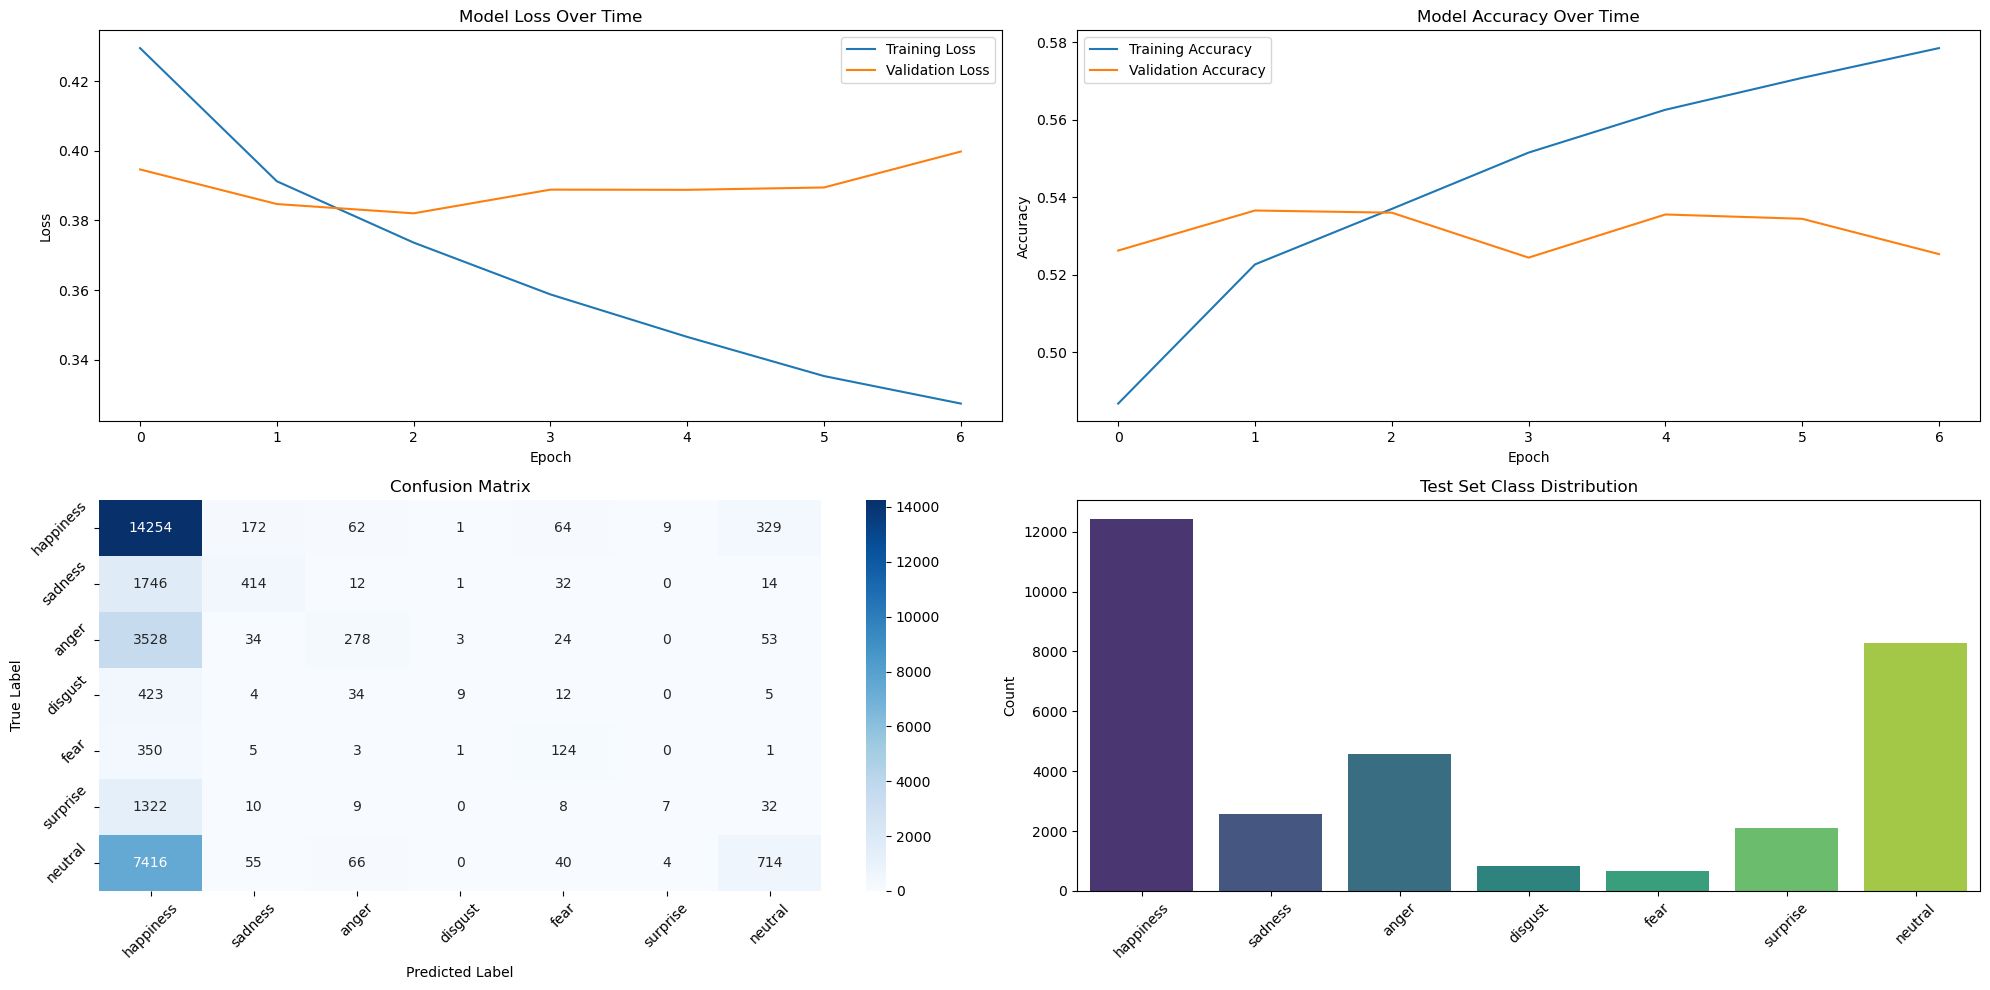

c:\Users\35988\anaconda3\envs\BLock_C_Year_2\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\35988\anaconda3\envs\BLock_C_Year_2\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\35988\anaconda3\envs\BLock_C_Year_2\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()}

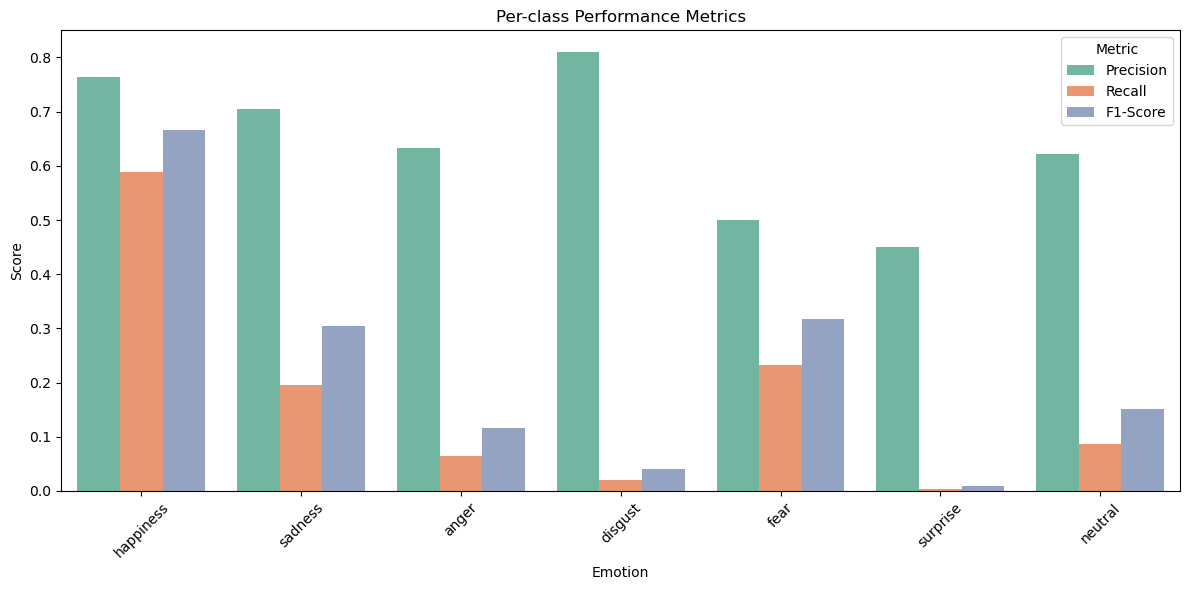

In [18]:
# Cell 9: Create visualizations
# Set up the plotting style
plt.style.use('default')
fig = plt.figure(figsize=(20, 10))

# 1. Training History Plot
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 2. Accuracy Plot
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 3. Confusion Matrix
plt.subplot(2, 2, 3)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_classes.argmax(axis=1))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=list(emotion_mapping.keys()),
    yticklabels=list(emotion_mapping.keys())
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# 4. Class Distribution
plt.subplot(2, 2, 4)
class_counts = y_test.sum(axis=0)
sns.barplot(
    x=list(emotion_mapping.keys()),
    y=class_counts,
    palette='viridis'
)
plt.title('Test Set Class Distribution')
plt.xticks(rotation=45)
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Additional visualization: Per-class performance
plt.figure(figsize=(12, 6))
metrics = ['precision', 'recall', 'f1-score']  # Changed to lowercase, matching classification_report keys
class_performance = classification_report(
    y_test, 
    y_pred_classes,
    target_names=list(emotion_mapping.keys()),
    output_dict=True
)

# Create performance comparison plot
performance_data = []
for emotion in emotion_mapping.keys():
    for metric in metrics:
        performance_data.append({
            'Emotion': emotion,
            'Metric': metric.replace('_', ' ').title(),  # Format for display
            'Score': class_performance[emotion][metric]  # Direct access without manipulation
        })

performance_df = pd.DataFrame(performance_data)
sns.barplot(
    data=performance_df,
    x='Emotion',
    y='Score',
    hue='Metric',
    palette='Set2'
)
plt.title('Per-class Performance Metrics')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
# Cell 10: Save model and artifacts
# Create directory if it doesn't exist
import os
save_dir = 'Task4/model_artifacts'
os.makedirs(save_dir, exist_ok=True)

# 1. Save the model
model.save(f'{save_dir}/emotion_lstm_model_2.h5')

# 2. Save tokenizer
import pickle
with open(f'{save_dir}/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 3. Save emotion mapping
with open(f'{save_dir}/emotion_mapping.pickle', 'wb') as handle:
    pickle.dump(emotion_mapping, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 4. Save model parameters
model_params = {
    'MAX_LENGTH': MAX_LENGTH,
    'VOCAB_SIZE': VOCAB_SIZE,
    'EMBEDDING_DIM': EMBEDDING_DIM,
    'class_weights': class_weights
}
with open(f'{save_dir}/model_params.pickle', 'wb') as handle:
    pickle.dump(model_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 5. Save training history
with open(f'{save_dir}/training_history.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 6. Save evaluation metrics
evaluation_metrics = {
    'classification_report': classification_report(
        y_test, 
        y_pred_classes,
        target_names=list(emotion_mapping.keys()),
        output_dict=True
    ),
    'confusion_matrix': cm.tolist()
}
with open(f'{save_dir}/evaluation_metrics.pickle', 'wb') as handle:
    pickle.dump(evaluation_metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Model and all artifacts saved in {save_dir}")

# Save confusion matrix plot separately
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=list(emotion_mapping.keys()),
    yticklabels=list(emotion_mapping.keys())
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(f'{save_dir}/confusion_matrix.png')
plt.close()

c:\Users\35988\anaconda3\envs\BLock_C_Year_2\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\35988\anaconda3\envs\BLock_C_Year_2\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\35988\anaconda3\envs\BLock_C_Year_2\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()}

Model and all artifacts saved in Task4/model_artifacts
